In [1]:
from time import time

import pickle

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import onlinehd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(1234)
torch.manual_seed(1234)

# Prepare Neural Network

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
%matplotlib inline

# Dataset

In [3]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class CustomImageDataset(Dataset):
    def __init__(self, df, data_type = 'train', model_type='ffnn'):
        """
        :param df: data frame
        :param rating_2014_file: 'train'/'test'
        :param model_type: 'ffnn'/'cnn'
        """
        if data_type == 'train':
            self.X = df.drop('label', axis=1).values/255.
            self.Y = df['label'].values
        else:
            self.X = df.values/255.
            self.Y = None
        self.X = torch.from_numpy(self.X.astype(np.float32)).reshape(len(df),28, 28)
        self.data_type = data_type
        self.model_type = model_type

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.data_type == 'train':
            label = self.Y[idx]
        else:
            label = None
        
        if self.model_type == 'ffnn':
            return image, label
        else:
            # add additional dimension if we need dataset for cnn
            return image.unsqueeze(0), label

In [4]:
x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
x = x.astype(np.float)
y = y.astype(np.int)
y = np.array(y)

x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)

x['label'] = y
x_test['label'] = y_test

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_70480/3224256213.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_70480/3224256213.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [5]:
df_train = x
df_val = x_test

# Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# convolutional nn
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # input torch.Size([64, 1, 28, 28])
        # torch.Size([batch_size, channels, img_width, img_height])
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4)
        # torch.Size([64, 16, 28-kernel_size+1, 28-kernel_size+1])
        # torch.Size([64, 16, 25, 25])
        self.relu1=nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2)
        
        # torch.Size([64, 8, 24, 24])
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=2)
        
        # torch.Size([64, 8, 12, 12])
        self.fc1 = nn.Linear(8*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        out=self.conv1(x)
        out=self.relu1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.max_pool2(out)
        
        out = torch.flatten(out, 1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

In [7]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn, result_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    result_dict['avg_loss'].append(test_loss)
    result_dict['acc'].append(correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def plot_results(axs, res_dict):
    
    axs[0].plot(res_dict['epoch'][-10:], res_dict['acc'][-10:], c='r')
    axs[0].set_title('Validation accuracy {:.4f}'.format(res_dict['acc'][-1]))
    
    axs[1].plot(res_dict['epoch'][-10:], res_dict['avg_loss'][-10:], c='r')
    axs[1].set_title('Average validation loss {:.4f}'.format(res_dict['avg_loss'][-1]))
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Convolutional neural network

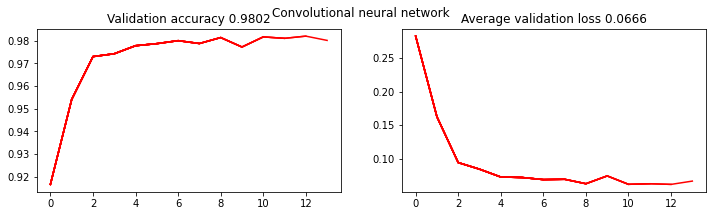

Epoch 15
-------------------------------
loss: 0.015762  [    0/52500]
loss: 0.046820  [12800/52500]
loss: 0.024788  [25600/52500]
loss: 0.041630  [38400/52500]
loss: 0.034975  [51200/52500]
INFO: Early stopping counter 5 of 5
INFO: Early stopping


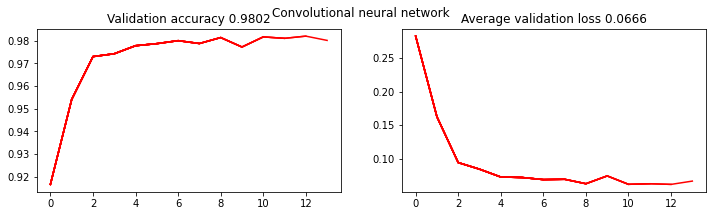

In [9]:
BATCH_SIZE = 128
EPOCHS = 30

training_data = CustomImageDataset(df_train, model_type='cnn')
val_data = CustomImageDataset(df_val, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

model_cnn = CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn, loss_fn, optimizer)
    test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [10]:
model = model_cnn
dataloader = val_dataloader

size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

test_loss, correct

(0.062207314991358204, 0.9818285714285714)

In [27]:
import pickle

with open('hd_adversarial_sample/MNIST_hd_FGSM.pickle', 'rb') as f:
    mnist_cnn_fgsm = pickle.load(f)
    
with open('hd_adversarial_sample/MNIST_hd_DF.pickle', 'rb') as f:
    mnist_cnn_df = pickle.load(f)
    
with open('hd_adversarial_sample/MNIST_hd_JSMA.pickle', 'rb') as f:
    mnist_cnn_jsma = pickle.load(f)

In [58]:
mnist_cnn_fgsm_data = torch.from_numpy(mnist_cnn_fgsm['data']['0.01'].reshape(-1, 784).detach().numpy()).float()
mnist_cnn_fgsm_label = mnist_cnn_fgsm['label'].long()

In [59]:
mnist_cnn_df_data = mnist_cnn_df['data'].float()
mnist_cnn_df_label = mnist_cnn_df['label']

In [60]:
mnist_cnn_jsma_data = mnist_cnn_jsma['data'].reshape(-1, 784).float()
mnist_cnn_jsma_label = mnist_cnn_jsma['label']

In [61]:
for i in range(len(mnist_cnn_fgsm_data)):
    max_ = mnist_cnn_fgsm_data[i].max()
    min_ = mnist_cnn_fgsm_data[i].min()
    
    mnist_cnn_fgsm_data[i] = (mnist_cnn_fgsm_data[i] - min_) / (max_ - min_)

for i in range(len(mnist_cnn_df_data)):
    max_ = mnist_cnn_df_data[i].max()
    min_ = mnist_cnn_df_data[i].min()
    
    mnist_cnn_df_data[i] = (mnist_cnn_df_data[i] - min_) / (max_ - min_)
    
for i in range(len(mnist_cnn_jsma_data)):
    max_ = mnist_cnn_jsma_data[i].max()
    min_ = mnist_cnn_jsma_data[i].min()
    
    mnist_cnn_jsma_data[i] = (mnist_cnn_jsma_data[i] - min_) / (max_ - min_)

In [62]:
print('Validating...')

yhat_mnist_fgsm = model(mnist_cnn_fgsm_data.reshape(-1, 1, 28, 28)).argmax(1)
yhat_mnist_df = model(mnist_cnn_df_data.reshape(-1, 1, 28, 28)).argmax(1)
yhat_mnist_jsma = model(mnist_cnn_jsma_data.reshape(-1, 1, 28, 28)).argmax(1)

acc_fgsm = (mnist_cnn_fgsm_label == yhat_mnist_fgsm).float().mean()
acc_df = (mnist_cnn_df_label == yhat_mnist_df).float().mean()
acc_jsma = (mnist_cnn_jsma_label == yhat_mnist_jsma).float().mean()


print(f'{acc_fgsm = :6f}')
print(f'{acc_df = :6f}')
print(f'{acc_jsma = :6f}')
print(f'{t = :6f}')

Validating...
acc_fgsm = 0.974171
acc_df = 0.964629
acc_jsma = 0.957371
t = 14.000000
